# RC section mesh

In [11]:
import numpy as np
import openseespy.opensees as ops
import opstool as opst

## Generate geometric objects

In [12]:
# the points of the outer contour line, only the turning point of the line is needed, counterclockwise or clockwise.
outlines = [[0.5, 0], [7.5, 0], [8, 0.5], [8, 4.5],
            [7.5, 5], [0.5, 5], [0, 4.5], [0, 0.5]]
# cover thick
cover_d = 0.08
# Offset to get the inner boundary of the cover layer
coverlines = opst.offset(outlines, d=cover_d)

# Generate polygonal geometry object for cover layer
cover = opst.add_polygon(outlines, holes=[coverlines])

# Creating core with voids
holelines1 = [[1, 1], [3.5, 1], [3.5, 4], [1, 4]]
holelines2 = [[4.5, 1], [7, 1], [7, 4], [4.5, 4]]
core = opst.add_polygon(coverlines, holes=[holelines1, holelines2])

## Generate mesh

In [13]:
sec = opst.SecMesh(sec_name="My Fiber Section")
# Grouping, the dict key is the group name, which can be arbitrary.
sec.assign_group(dict(cover=cover, core=core))
# Specify the grid size
sec.assign_mesh_size(dict(cover=0.2, core=0.4))
sec.assign_group_color(dict(cover="gray", core="green"))
# Specify the material tag in the opensees, the material needs to be defined by you beforehand.
ops.uniaxialMaterial('Concrete01', 1, -30, -0.002, -15, -0.005)
ops.uniaxialMaterial('Concrete01', 2, -40, -0.006, -30, -0.015)
sec.assign_ops_matTag(dict(cover=1, core=2))
# mesh!
sec.mesh()

## add rebars

In [29]:
ops.uniaxialMaterial('Steel01', 3, 200, 2.E5, 0.02)
# Instantiating the rebar class
rebars = opst.Rebars()

rebar_d_outer = 0.032   # dia of rebar
rebar_d_inner = 0.02
# Offset to obtain the rebars arranged along the contour line, Inward offset is positive
rebar_lines1 = opst.offset(outlines, d=cover_d + rebar_d_outer / 2)
# add the rebar line, gap is the spacing of the rebars, matTag is the opensees material tag predefined.
rebars.add_rebar_line(
    points=rebar_lines1, dia=rebar_d_outer, gap=0.15, color="red", matTag=3
)
# Offset to obtain the rebars arranged along the holes
rebar_lines2 = opst.offset(holelines1, d=-(cover_d + rebar_d_inner / 2))
rebars.add_rebar_line(
    points=rebar_lines2, dia=rebar_d_inner, gap=0.2, color="black", matTag=3
)
rebar_lines3 = opst.offset(holelines2, d=-(cover_d + rebar_d_inner / 2))
rebars.add_rebar_line(
    points=rebar_lines3, dia=rebar_d_inner, gap=0.2, color="black", matTag=3
)

In [15]:
# add to the sec
sec.add_rebars(rebars)

## Get the section properties

In [16]:
sec_props = sec.get_sec_props(display_results=True, plot_centroids=False)
# for key, value in sec_props.items():
#     print(f"{key}: {value}")

                    Section Properties                    
┏━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Symbol    ┃ Value          ┃ Definition                ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ A         │ 24.500         │ Cross-sectional area      │
│ Asy       │ 13.963         │ Shear area y-axis         │
│ Asz       │ 12.119         │ Shear area z-axis         │
│ centroid  │ (4.000, 2.500) │ Elastic centroid          │
│ Iy        │ 69.354         │ Moment of inertia y-axis  │
│ Iz        │ 152.229        │ Moment of inertia z-axis  │
│ Iyz       │ 0.000          │ Product of inertia        │
│ J         │ 158.253        │ Torsion constant          │
│ phi       │ -90.000        │ Principal axis angle      │
│ rho_rebar │ 0.007          │ Ratio of reinforcement    │
│ E_eff     │ 1.000          │ Effective elastic modulus │
│ G_eff     │ 0.500          │ Effective shear modulus   │
│ Nu_eff    │ 0.000          │ Effective Poisson’s ratio │
└───────────┴────────────────┴───────────────────────────┘

## centering or rotate the section

In [17]:
sec.centring()
#sec.rotate(90)

## View the section mesh

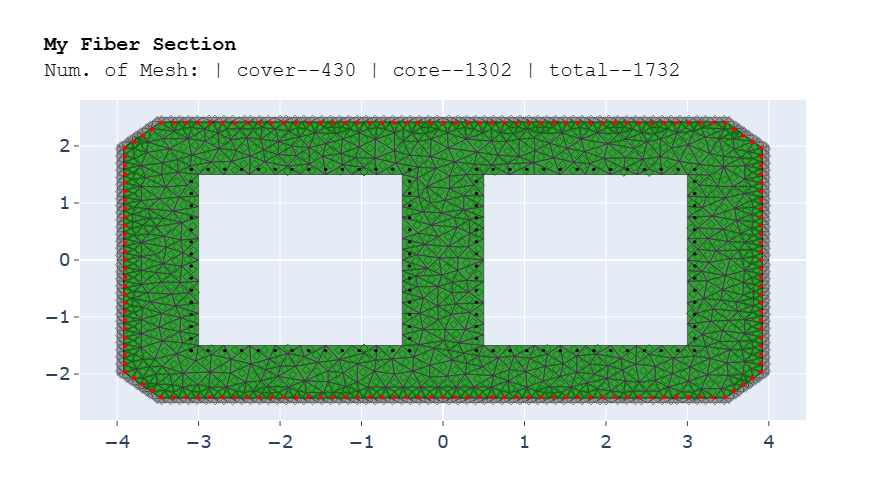

In [18]:
sec.view(fill=True, engine='plotly', save_html=None, on_notebook=True)

and engine='matplotlib'

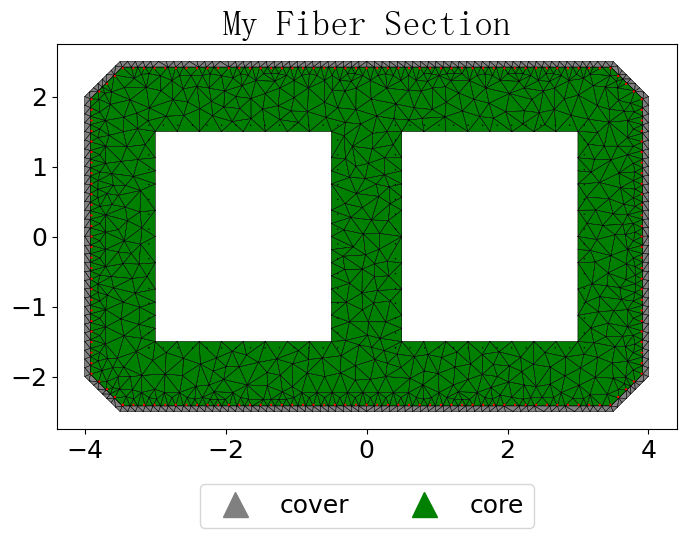

In [19]:
sec.view(fill=True, engine='matplotlib')

## Generate py or tcl file

In [20]:
G = 10000   # Shear modulus
sec.to_file("mysec.py", secTag=1, GJ=G * sec_props['J'])
# sec.to_file("mysec.tcl", secTag=1, GJ=G * sec_props['J'])

## Generate openseespy cmds implicitly

It's done, you don't need to do anything more.

# Composite Section Mesh

In [1]:
import numpy as np
import opstool as opst

Specify the characteristics of each material

In [3]:
Ec = 3.45E7
Es = 2.0E8
Nus = 0.3
Nuc = 0.2
steel_mat = opst.add_material(name='steel', elastic_modulus=Es, poissons_ratio=Nus)
conc_mat = opst.add_material(name='conc', elastic_modulus=Ec, poissons_ratio=Nuc)

Use predefined materials when generating geometric objects

In [4]:
outlines = [[0, 0], [2, 0], [2, 2], [0, 2]]
coverlines = opst.offset(outlines, d=0.05)
cover = opst.add_polygon(outlines, holes=[coverlines], material=conc_mat)
bonelines = [[0.5, 0.5], [1.5, 0.5], [1.5, 0.7], [1.1, 0.7], [1.1, 1.3], [1.5, 1.3], [1.5, 1.5],
             [0.5, 1.5], [0.5, 1.3], [0.9, 1.3], [0.9, 0.7], [0.5, 0.7], [0.5, 0.5]]
core = opst.add_polygon(coverlines, holes=[bonelines], material=conc_mat)
bone = opst.add_polygon(bonelines, material=steel_mat)

mesh

In [8]:
sec = opst.SecMesh()
sec.assign_group(dict(cover=cover, core=core, bone=bone))
sec.assign_mesh_size(dict(cover=0.02, core=0.05, bone=0.02))
sec.assign_group_color(dict(cover="gray", core="#b84592", bone='#ffc168'))
sec.assign_ops_matTag(dict(cover=1, core=2, bone=4))
sec.mesh()

add rebars

In [9]:
# add rebars
rebars = opst.Rebars()
rebar_lines1 = opst.offset(outlines, d=0.05 + 0.032 / 2)
rebars.add_rebar_line(
    points=rebar_lines1, dia=0.032, gap=0.1, color="red", matTag=3
)
# add to the sec
sec.add_rebars(rebars)

In [7]:
sec_props = sec.get_sec_props(Eref=Es, display_results=True)

                    Section Properties                    
┏━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Symbol    ┃ Value          ┃ Definition                ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ A         │ 1.120          │ Cross-sectional area      │
│ Asy       │ 0.923          │ Shear area y-axis         │
│ Asz       │ 0.786          │ Shear area z-axis         │
│ centroid  │ (1.000, 1.000) │ Elastic centroid          │
│ Iy        │ 0.287          │ Moment of inertia y-axis  │
│ Iz        │ 0.258          │ Moment of inertia z-axis  │
│ Iyz       │ -0.000         │ Product of inertia        │
│ J         │ 0.428          │ Torsion constant          │
│ phi       │ 0.000          │ Principal axis angle      │
│ rho_rebar │ 0.052          │ Ratio of reinforcement    │
│ E_eff     │ 56015000.000   │ Effective elastic modulus │
│ G_eff     │ 22506250.000   │ Effective shear modulus   │
│ Nu_eff    │ 0.244          │ Effective Poisson’s ratio │
└───────────┴────────────────┴───────────────────────────┘

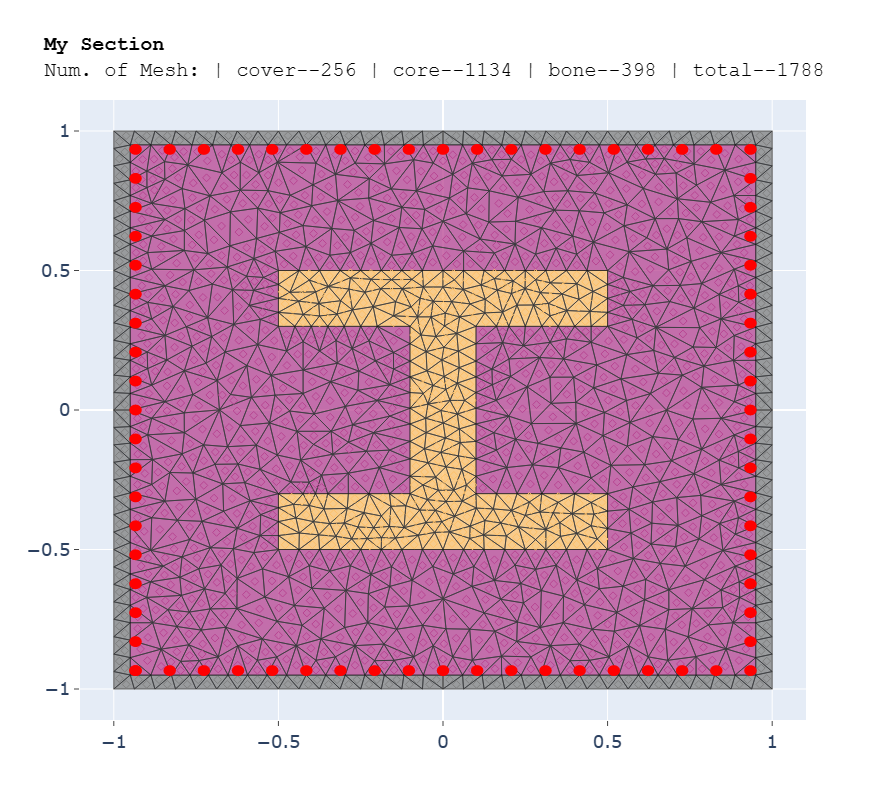

In [10]:
sec.centring()
sec.view(fill=True, engine='plotly', save_html=None, on_notebook=True)

output the file

In [28]:
Gs = Es / 2 / (1 + Nus)
sec.to_file("mysec.py", secTag=1, GJ=Gs * sec_props['J'])

# Variable section mesh

In [5]:
import numpy as np
import opstool as opst

In [10]:
# I end
outlines1 = [[0.5, 0], [7.5, 0], [8, 0.5], [8, 4.5],
            [7.5, 5], [0.5, 5], [0, 4.5], [0, 0.5]]
cover_d = 0.08
coverlines1 = opst.offset(outlines1, d=cover_d)
holelines1i = [[1, 1], [3.5, 1], [3.5, 4], [1, 4]]
holelines2i = [[4.5, 1], [7, 1], [7, 4], [4.5, 4]]
# J end
outlines2 = [[0.5, 0], [7.5, 0], [8, 0.5], [8, 2.5],
             [7.5, 3], [0.5, 3], [0, 2.5], [0, 0.5]]
cover_d = 0.05
coverlines2 = opst.offset(outlines2, d=cover_d)
holelines1j = [[1, 1], [3.5, 1], [3.5, 2], [1, 2]]
holelines2j = [[4.5, 1], [7, 1], [7, 2], [4.5, 2]]

In [11]:
path = [(0, 0, 0), (8, 0, 8), (16, 0, 12), (24, 0, 15)]   # 3 beam elements

In [12]:

outlines = opst.var_line_string(pointsi=outlines1, pointsj=outlines2,
                                path=path, n_sec=5, closure=True,
                                y_degree=1, y_sym_plane="j-0",
                                z_degree=2, z_sym_plane="j-0")
coverlines = opst.var_line_string(pointsi=coverlines1, pointsj=coverlines2,
                                  path=path, n_sec=5, closure=True,
                                  y_degree=1, y_sym_plane="j-0",
                                  z_degree=2, z_sym_plane="j-0")
holelines1 = opst.var_line_string(pointsi=holelines1i, pointsj=holelines1j,
                                  path=path, n_sec=5, closure=True,
                                  y_degree=1, y_sym_plane="j-0",
                                  z_degree=2, z_sym_plane="j-0")
holelines2 = opst.var_line_string(pointsi=holelines2i, pointsj=holelines2j,
                                  path=path, n_sec=5, closure=True,
                                  y_degree=1, y_sym_plane="j-0",
                                  z_degree=2, z_sym_plane="j-0")

In [15]:
sec_meshes = []
for i in range(len(outlines)):
    cover = opst.add_polygon(outlines[i], holes=[coverlines[i]])
    core = opst.add_polygon(coverlines[i], holes=[holelines1[i], holelines2[i]])
    sec = opst.SecMesh(sec_name=f"Section{i+1}")
    sec.assign_group(dict(cover=cover, core=core))
    sec.assign_mesh_size(dict(cover=0.2, core=0.4))
    sec.assign_group_color(dict(cover="gray", core="green"))
    sec.assign_ops_matTag(dict(cover=1, core=2))
    # mesh!
    sec.mesh()
    rebars = opst.Rebars()
    rebar_d_outer = 0.06   # dia of rebar
    rebar_d_inner = 0.06
    rebar_lines1 = opst.offset(coverlines[i], d=rebar_d_outer / 2)
    rebars.add_rebar_line(points=rebar_lines1, dia=rebar_d_outer,
                          gap=0.15, color="red", matTag=3)
    rebar_lines2 = opst.offset(holelines1[i], d=-(cover_d + rebar_d_inner / 2))
    rebars.add_rebar_line(
        points=rebar_lines2, dia=rebar_d_inner, gap=0.2, color="black", matTag=3
    )
    rebar_lines3 = opst.offset(holelines2[i], d=-(cover_d + rebar_d_inner / 2))
    rebars.add_rebar_line(
        points=rebar_lines3, dia=rebar_d_inner, gap=0.2, color="black", matTag=3
    )
    sec.add_rebars(rebars)
    sec.centring()  # must here
    sec_meshes.append(sec)

In [9]:
opst.vis_var_sec(sec_meshes=sec_meshes, path=path,
                 n_sec=5, on_notebook=False)